## Testing saving interpolated outputs from IFS Cycle 3
### Playing with the lifecycle of blocks

In [1]:
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake

#from contrack import contrack
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib import cm

##
# Import Cdo-py
import cdo
cdo = cdo.Cdo(tempdir='/scratch/m/m300265/tmp/cdo-py') #change the tempdir to your scratch

In [2]:
def attach_coords(ds):
    model_lon = ds.lon.values
    model_lat = ds.lat.values
    return ds.assign_coords(
        lat = (("value",), model_lat, {"units": "degree_north"}),
        lon = (("value",), model_lon, {"units": "degree_east"}),
    )


In [3]:
def convert_to_xarray(ds,var,grid='025'):
    # select a variable, reshape lat lon and convert to XArray DataArray
    # needs to specify an existing varname e.g. '2t'
    # assumes that ds has the shape time | value
    
    # arrange value coordinate into lat/lon
#    sample = np.reshape(ds[var].values, newshape=(len(ds.time),len(np.unique(ds.lat)),len(np.unique(ds.lon))))
    sample = np.reshape(ds[var].sel(level=500.0).values, newshape=(len(ds.time),len(np.unique(ds.lat)),len(np.unique(ds.lon))))
    
    # create DataArray with proper name, dimensions, and coordinates
    da = xr.DataArray(
        data=sample,
        name=var,
        dims=["time", "lat", "lon"],
        coords=dict(
            time=ds.time.data,
            lon=(["lon"], np.unique(ds.lon)),
            # lat=(["lat"], np.unique(ds.lat)),
            lat=(["lat"], np.unique(ds.lat)[::-1]), # use this because otherwise lats are flipped; only comment for testing
        ),
        attrs=dict(
#             variable=var,
            ds[var].attrs,
            
        ),
    )
    
#    # attach griddes so that cdo interprets it as a regular lonlat grid:
#    if grid=='025':
#        my_griddes = '/work/bm1235/ifs-grids/multio_grids_cdoPython/025_griddes'
#    elif grid=='1':
#        my_griddes = '/work/bm1235/ifs-grids/multio_grids_cdoPython/1_griddes'
#    else:
#        raise Exception("Unsupported grid. Maybe new grid introduced in multIO?")
#        
#    da = cdo.setgrid(my_griddes, input=da.to_dataset(), returnXDataset=True)[var]
    
    return da

In [4]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [5]:
# which IFS experiments are available? Which streams are in the IFS catalog for experiment 'IFS_4.4-FESOM_5-cycle3'?
print(list(cat.IFS))
print(list(cat.IFS['IFS_4.4-FESOM_5-cycle3'])) # tco2559-ng5-cycle3 will soon be removed

['IFS_4.4-FESOM_5-cycle3', 'IFS_9-FESOM_5-cycle3', 'IFS_9-NEMO_25-cycle3', 'IFS_28-NEMO_25-cycle3', 'IFS_4.4-FESOM_5-cycle3-nofastdata', 'IFS_4.4-FESOM_5-cycle3-fastdata', 'IFS_grids']
['2D_1h_native', '3D_1h6h_native', '2D_monthly_native', '3D_monthly_native', '2D_monthly_0.25deg', '3D_monthly_0.25deg', '2D_1h_0.25deg', '3D_1h6h_0.25deg', '2D_monthly_1deg', '3D_monthly_1deg', '2D_1h_1deg', '3D_1h6h_1deg', 'WAM_1h_native']


In [7]:
##Original resolution
#data = cat.IFS['IFS_4.4-FESOM_5-cycle3']['3D_1h6h_1deg'].to_dask() # load lower-resolution here
##Resampling to daily
data = cat.IFS['IFS_4.4-FESOM_5-cycle3']['3D_1h6h_1deg'].to_dask().resample(time='1D').mean()

In [9]:
#data

In [10]:
# get ttr, tsr, 2t and reshape to (#lat x #lon) numpy array
#z500 = data.z.sel(level=500.0)
ifs_z = convert_to_xarray(data,var='z',grid='1')   # z500

In [12]:
#ifs_z

In [ ]:
###remove file
#!rm /scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5/z500/z500_ifs_c3.nc

In [13]:
ifs_z.to_netcdf('/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5/z500/z500_ifs_c3_test_1D.nc')

In [ ]:
#geop_ifs.time

# Testing blocking detection

In [14]:
#%pip install contrack
###== load contrack
from contrack import contrack
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib import cm

In [15]:
#ifs_data=xr.open_dataset('/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5/z500/z500_ifs_c3.nc')
ifs_data=xr.open_dataset('/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5/z500/z500_ifs_c3_test_1D.nc')

### Dealing with timedelta

In [16]:
#ifs_data.dt.year
#ifs_data.astype("datetime64[s]")
#tmp=ifs_data.sel(time=ifs_data.time.dt.hour.isin([0,6,12,18]))


In [17]:

#tmp.time
#tmp.time.astype('int')
#ifs_data['time'] #= pd.to_timedelta(pd.to_datetime(ifs_data['time']).dt.strftime('%H:%M:%S'))

In [18]:
outpath = '/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5/block/ANO_Z500'

In [20]:
#subfix='-ifs_4.4-fesom_5'
subfix='-ifs_4.4-fesom_5_full_1d'

In [21]:
###OUTFILE NAME
outfile_flag='BLOCKS'+subfix+'.nc'
outfile_table='BLOCKS'+subfix+'.csv'

In [22]:
### Take geopotential
#in_z_500=xr_in.z.sel(plev=50000.0)
#z_dataset=xr.DataArray.to_dataset(ifs_data)
#ifs_data.indexes['time'].normalize()

In [24]:
### intitate
block = contrack()
#block.read_xarray(tmp)
block.read_xarray(ifs_data)
#ifs_data=xr.DataArray.to_dataset(ifs_z)
#block.read_xarray(ifs_data)

In [25]:
# calculate geopotential height
block.calculate_gph_from_gp(gp_name='z',
                            gp_unit='m**2 s**-2',
                            gph_name='z_height')

INFO: Calculating GPH from GP... DONE


In [26]:
#block

In [28]:
#block.set_up(force=True)
block.ds=block.ds.compute()

In [30]:
# calculate Z500 anomaly (temporally smoothed with a 2 d running mean) with respect to the 31-day running mean (long-term: 30 years) climatology
block.calc_anom(variable='z_height',
                smooth=2,
                window=31,
                groupby='dayofyear')

INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'

INFO: Calculating climatological mean from z_height...
INFO: Calculating Anomaly... DONE


In [31]:
# Finally, track blocking anticyclones (>=150gmp, 50% overlap twosided, 5 timesteps persistence (here 5 days))
block.run_contrack(variable='anom',
                   threshold=160,
                   gorl='>=',
                   overlap=0.5,
                   persistence=5,
                   twosided=True)

INFO: 
Run ConTrack 
########### 
    threshold:    >= 160 
    overlap:      0.5 
    persistence:  5 time steps
INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'

INFO: Find individual contours...
INFO: Apply overlap...
INFO: Apply persistence...
INFO: Create new variable 'flag'...
INFO: Running contrack... DONE
250 contours tracked


In [32]:
# save to disk
block['flag'].to_netcdf(outpath+'/'+outfile_flag,unlimited_dims='time')

In [33]:
block_df = block.run_lifecycle(flag='flag', variable='anom')
block_df.to_csv(outpath+'/'+outfile_table, index=False)

INFO: 
Run Lifecycle 
########### 
    flag:    flag
    variable:    anom
INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'



# Load detected blockings

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib import cm

In [1]:

##==ifs block
#full_ifs = xr.open_dataset('/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5/block/ANO_Z500/BLOCKS-ifs_4.4-fesom_5.nc')                          
#full_ifs = xr.open_dataset('/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5/block/ANO_Z500/BLOCKS-ifs_4.4-fesom_5_full_p90.nc')   
#full_ifs = xr.open_dataset('/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5/block/ANO_Z500/BLOCKS-ifs_4.4-fesom_5_full_v3.nc')
#full_ifs = xr.open_dataset('/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5/block/ANO_Z500/BLOCKS-ifs_4.4-fesom_5_full_0.8.nc')
#full_ifs = xr.open_dataset('/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5/block/ANO_Z500/BLOCKS-ifs_4.4-fesom_5_full_1d.nc')
#full_ifs = xr.open_dataset('/scratch/b/b382006/nextgems/cycle2/ngc2013/block/ANO_Z500/BLOCKS-icon-ngc2013-p1.nc')

In [35]:
full_ifs

<xarray.Dataset>
Dimensions:  (time: 1809, lon: 360, lat: 181)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-01-21 ... 2025-01-01
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 90.0 89.0 88.0 87.0 86.0 ... -87.0 -88.0 -89.0 -90.0
Data variables:
    flag     (time, lat, lon) int32 ...

In [4]:
### select season
#full_ifs.sel(time=full_ifs.time.dt.month.isin([6,7,8]))
#full_ifs.sel(time='2020-03-08T12:00:00')

In [36]:
### accumulate ifs
cntime_ifs_djf =len(full_ifs.time)
cacc_ifs_djf = xr.where(full_ifs['flag']>1,1,0).sum(dim='time')/cntime_ifs_djf*100

Text(0.5, 1.0, 'IFS_4.4-FESOM_5-cycle3 [2020-2024]')

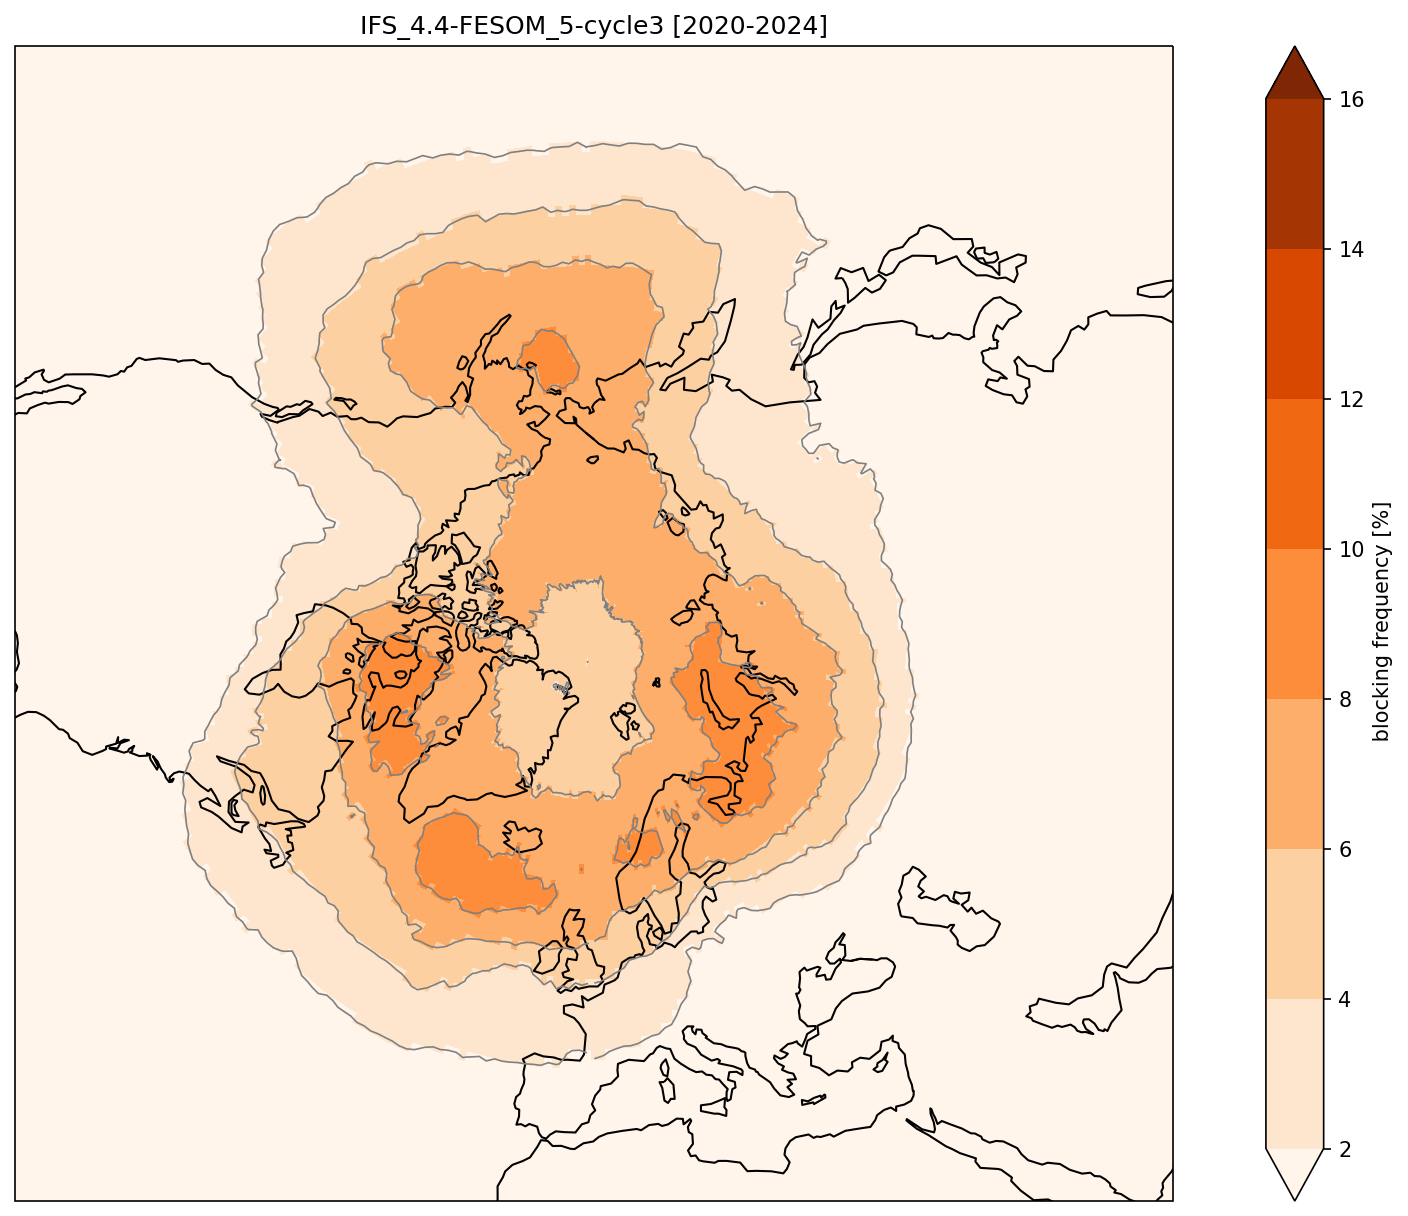

In [37]:
###### ANO Z500 index plot in DJF
sufix='DJF'
clevels=[-10,-8,-6,-5,-4,-3,-2,-1.5,-1,1,1.5,2,3,4,5,6,8,10]
mlevels=np.arange(2,18,2)
### ABS index plot in DJF
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10), dpi=150, subplot_kw={'projection': ccrs.NorthPolarStereo()})
###==== first panel
im1=cacc_ifs_djf.plot(ax=ax1,levels=mlevels, cmap='Oranges', extend = 'both', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': ' blocking frequency [%]'})
cacc_ifs_djf.plot.contour(ax=ax1,colors='grey', linewidths=0.8, levels=mlevels, transform=ccrs.PlateCarree())

ax1.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree()); 
ax1.coastlines();

ax1.set_title('IFS_4.4-FESOM_5-cycle3 [2020-2024]')

### Save
#plt.savefig('Blocks_IFS_4.4-FESOM_5-cycle3.jpg')

###=== Add colorbar
#cbar_ax = fig.add_axes([0.2, 0.25, 0.6, 0.02])  # Left, bottom, width, height.
#cbar = fig.colorbar(im1, cax=cbar_ax, extend='both', orientation='horizontal')
#cbar.set_label(' Blocking (%)')

In [2]:
#####
import pandas as pd
####open tex files===
#ifs
#ccsv_ifs =  pd.read_csv('/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5/block/ANO_Z500/BLOCKS-ifs_4.4-fesom_5_full.csv', delimiter=',',header=0)
#ccsv_ifs =  pd.read_csv('/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5/block/ANO_Z500/BLOCKS-ifs_4.4-fesom_5_full_p90.csv', delimiter=',',header=0)
#ccsv_ifs =  pd.read_csv('/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5/block/ANO_Z500/BLOCKS-ifs_4.4-fesom_5_full_v3.csv', delimiter=',',header=0)
ccsv_ifs =  pd.read_csv('/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5/block/ANO_Z500/BLOCKS-ifs_4.4-fesom_5_full_0.8.csv', delimiter=',',header=0)
#ccsv_ifs =  pd.read_csv('/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5/block/ANO_Z500/BLOCKS-ifs_4.4-fesom_5_full_1d.csv', delimiter=',',header=0)
#ccsv_ifs =  pd.read_csv('/scratch/b/b382006/nextgems/cycle2/ngc2013/block/ANO_Z500/BLOCKS-icon-ngc2013-p1.csv', delimiter=',',header=0)

In [4]:
#ccsv_ifs[500:510]
ccsv_ifs.loc[ccsv_ifs['Intensity'].nlargest(10).index]

,Flag,Date,Longitude,Latitude,Intensity,Size
7155,4245,20230213_18,44,72,333.64,7856248.57
7154,4245,20230213_12,44,72,332.86,8163699.74
7156,4245,20230214_00,44,72,331.32,7610945.97
7153,4245,20230213_06,44,72,327.44,8644468.26
7157,4245,20230214_06,44,72,326.12,7421888.70
7152,4245,20230213_00,44,72,320.69,9173351.09
7158,4245,20230214_12,45,71,319.75,7205033.47
9271,5374,20240112_12,274,62,316.87,10614827.56
7151,4245,20230212_18,44,72,315.01,9616385.60
2590,1340,20210117_00,185,51,313.00,8990423.45


In [5]:
stg_block_date=ccsv_ifs.loc[ccsv_ifs['Date']=='20230214_00'] #date='2023-02-13T12:00:00'
print(stg_block_date)

      Flag         Date  Longitude  Latitude  Intensity        Size
7138  4237  20230214_00          0       -51     192.22  2327801.80
7156  4245  20230214_00         44        72     331.32  7610945.97
7190  4246  20230214_00        343        74     242.78  2058034.60
7210  4249  20230214_00        207        40     203.74  3735360.38


In [41]:
### take values in the northern hemosphere lat > 0 
#ccsv_ifs= ccsv_ifs[(ccsv_ifs['Latitude'] > 0 )]

In [42]:
### take values in Europe lon < 90
#ccsv_ifs= ccsv_ifs[(ccsv_ifs['Longitude'] < 60 )]

In [43]:
### Look for intense Block
ccsv_ifs_reset=ccsv_ifs.reset_index(drop=True)
ccsv_ifs_reset.loc[ccsv_ifs_reset['Intensity'].idxmax()]

Flag                2152
Date         20230214_00
Longitude             44
Latitude              72
Intensity         331.32
Size          7610945.97
Name: 1401, dtype: object

In [44]:
ccsv_ifs_reset.loc[ccsv_ifs_reset['Intensity'].nlargest(10).index]

,Flag,Date,Longitude,Latitude,Intensity,Size
1401,2152,20230214_00,44,72,331.32,7610945.97
1400,2152,20230213_00,44,72,320.69,9173351.09
5,2,20200121_00,340,52,318.33,6270444.37
501,640,20210117_00,185,51,312.83,9000545.47
6,2,20200122_00,339,52,311.82,6565668.11
1507,2229,20230328_00,200,57,308.74,12839836.36
57,57,20200225_00,200,59,308.46,9413162.42
44,37,20200215_00,323,48,306.58,8024598.72
1506,2229,20230327_00,200,54,304.81,12431658.54
43,37,20200214_00,318,47,303.98,7675731.81


In [45]:
stg_block=ccsv_ifs_reset.loc[ccsv_ifs_reset['Flag']==2152] #3345
stg_block_date=ccsv_ifs_reset.loc[ccsv_ifs_reset['Date']=='20230214_00'] #20230213_18
print(stg_block)#,stg_block_date)

      Flag         Date  Longitude  Latitude  Intensity         Size
1398  2152  20230211_00         41        70     260.22  10044881.92
1399  2152  20230212_00         44        71     296.16  10593072.04
1400  2152  20230213_00         44        72     320.69   9173351.09
1401  2152  20230214_00         44        72     331.32   7610945.97
1402  2152  20230215_00         46        71     303.50   6780620.69
1403  2152  20230216_00         52        69     270.92   5635303.35
1404  2152  20230217_00         60        67     245.72   4049119.32


<AxesSubplot:>

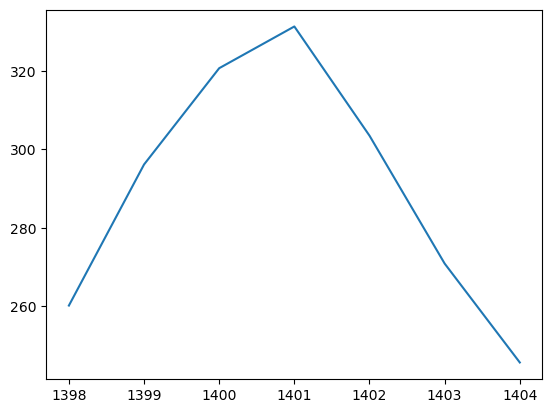

In [46]:
stg_block['Intensity'].plot()

Text(0.5, 1.0, 'IFS 4.4/NEMO 5 - Cycle 3 [2023-02-14T00:00:00]')

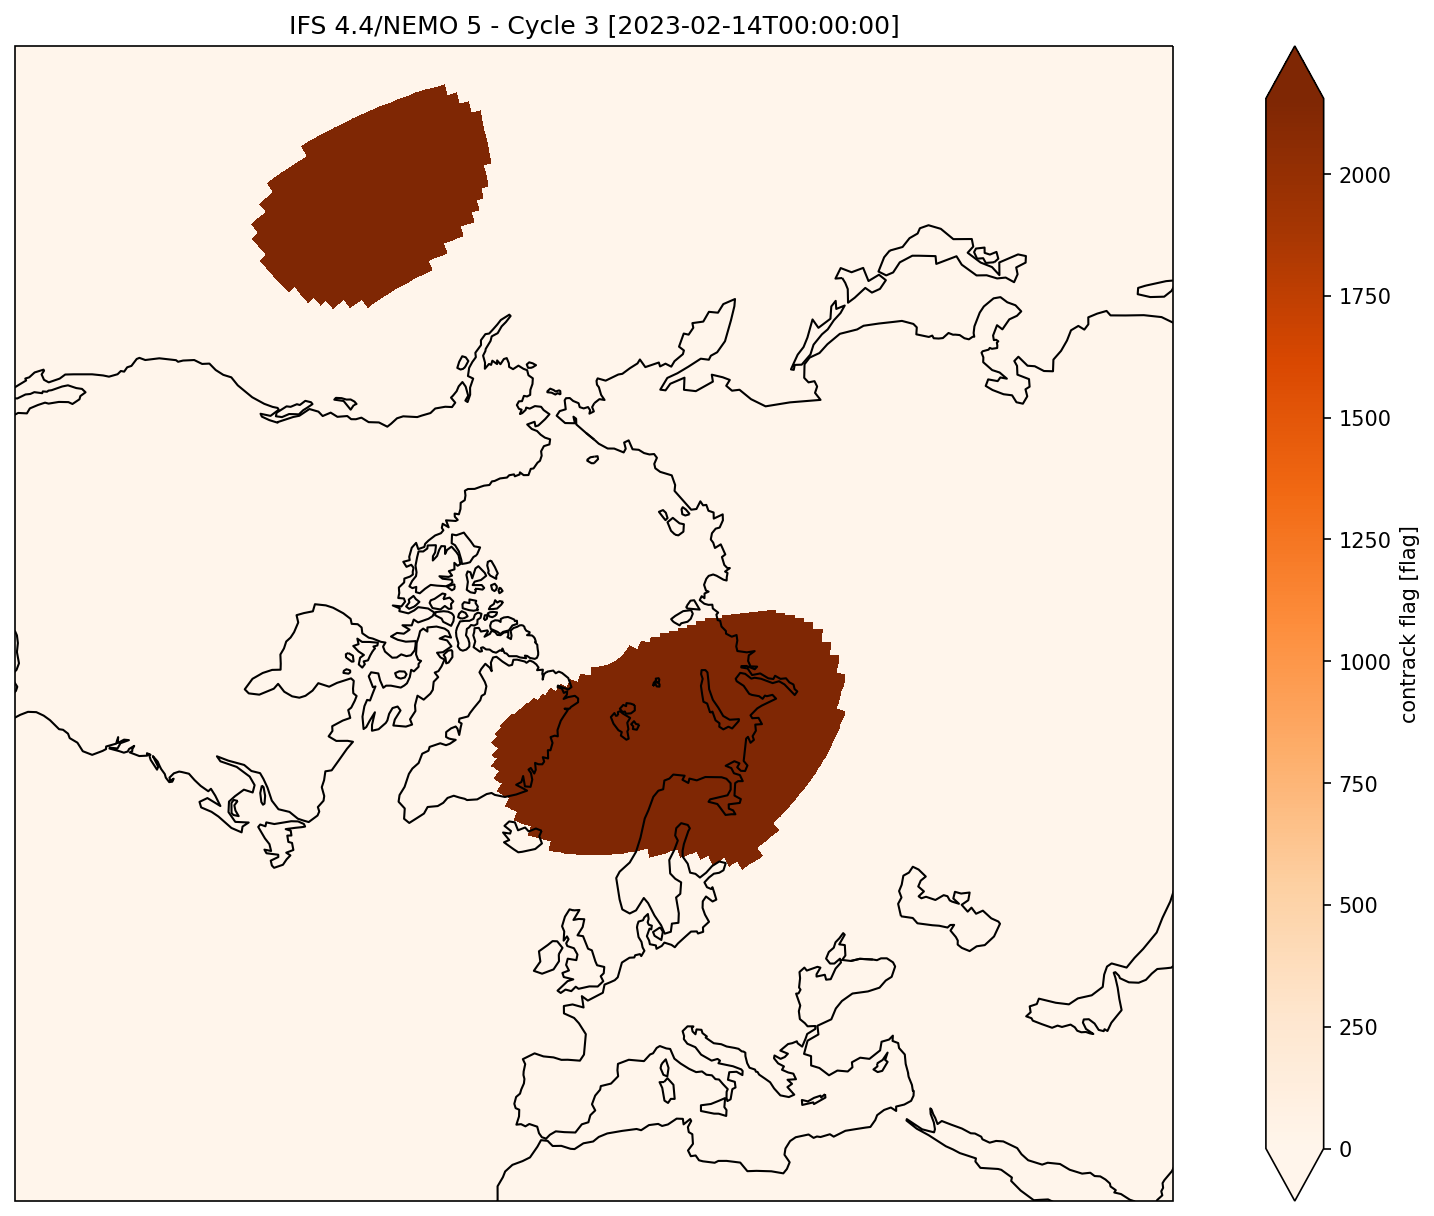

In [47]:
#full_ifs.flag[80,:].plot() 20200305_18 / 20230213_12 / 20210416_06 /20230606_12
#full_ifs.flag.sel(time='2020-01-29T12:00:00').plot() 
#date='2023-06-06T12:00:00'
date='2023-02-14T00:00:00'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10), dpi=150, subplot_kw={'projection': ccrs.NorthPolarStereo()})
im1=full_ifs.flag.sel(time=date).plot(ax=ax1, cmap='Oranges', extend = 'both', transform=ccrs.PlateCarree(),add_colorbar=True)
#cacc_ifs_djf.plot.contour(ax=ax1,colors='k', linewidths=0.8, levels=mlevels, transform=ccrs.PlateCarree())

ax1.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree()); 
ax1.coastlines();
ax1.set_title('IFS 4.4/NEMO 5 - Cycle 3 ['+date+']')

In [20]:
### Take summer months
#full_ifs_mjjas=full_ifs.sel(time=full_ifs.time.dt.month.isin([5,6,7,8,9]))

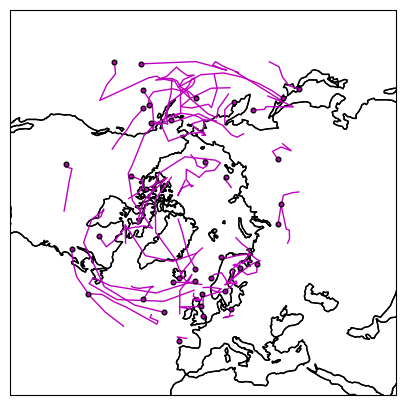

In [49]:
f, ax = plt.subplots(1, 1, figsize=(7,5), subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree()); ax.coastlines()
ax.coastlines() # add coastlines

block_df=ccsv_ifs
#need to split each blocking track due to longitude wrapping (jumping at map edge)
for bid in np.unique(np.asarray(block_df['Flag'][1:500])): #select blocking id
#for bid in range (2152,2153):
#    print(bid)
    lons = np.asarray(block_df['Longitude'].iloc[np.where(block_df['Flag']==bid)])
    lats = np.asarray(block_df['Latitude'].iloc[np.where(block_df['Flag']==bid)])

    # cosmetic: sometimes there is a gap near map edge where track is split:
    lons[lons >= 355] = 359.9
    lons[lons <= 3] = 0.1
    segment = np.vstack((lons,lats))

    #move longitude into the map region and split if longitude jumps by more than "threshold"
    lon0 = 0 #center of map
    bleft = lon0-0.
    bright = lon0+360
    segment[0,segment[0]> bright] -= 360
    segment[0,segment[0]< bleft]  += 360
    threshold = 180  # CHANGE HERE
    isplit = np.nonzero(np.abs(np.diff(segment[0])) > threshold)[0]
    subsegs = np.split(segment,isplit+1,axis=+1)

    #plot the tracks
    for seg in subsegs:
        x,y = seg[0],seg[1]
        ax.plot(x ,y,c = 'm',linewidth=1, transform=ccrs.PlateCarree())
    #plot the starting points
    ax.scatter(lons[0],lats[0],s=11,c='m', zorder=10, edgecolor='black', transform=ccrs.PlateCarree())

In [2]:
blocks_sims = xr.open_dataset('/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5/block/ANO_Z500/BLOCKS-ifs-daily.nc')
blocks_sims

<xarray.Dataset>
Dimensions:   (lat: 181, time: 1809, lon: 360)
Coordinates:
  * lat       (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * time      (time) datetime64[ns] 2020-01-20 2020-01-21 ... 2025-01-01
  * lon       (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Data variables:
    Blocking  (time, lat, lon) int64 ...

In [3]:
### accumulate ngc2003
ntime_sims = len(blocks_sims.time)
acc_sims = blocks_sims.Blocking.sum(dim='time')/ntime_sims*100

Text(0.5, 1.0, 'IFS_4.4-FESOM_5-cycle3 [2020-2024]')

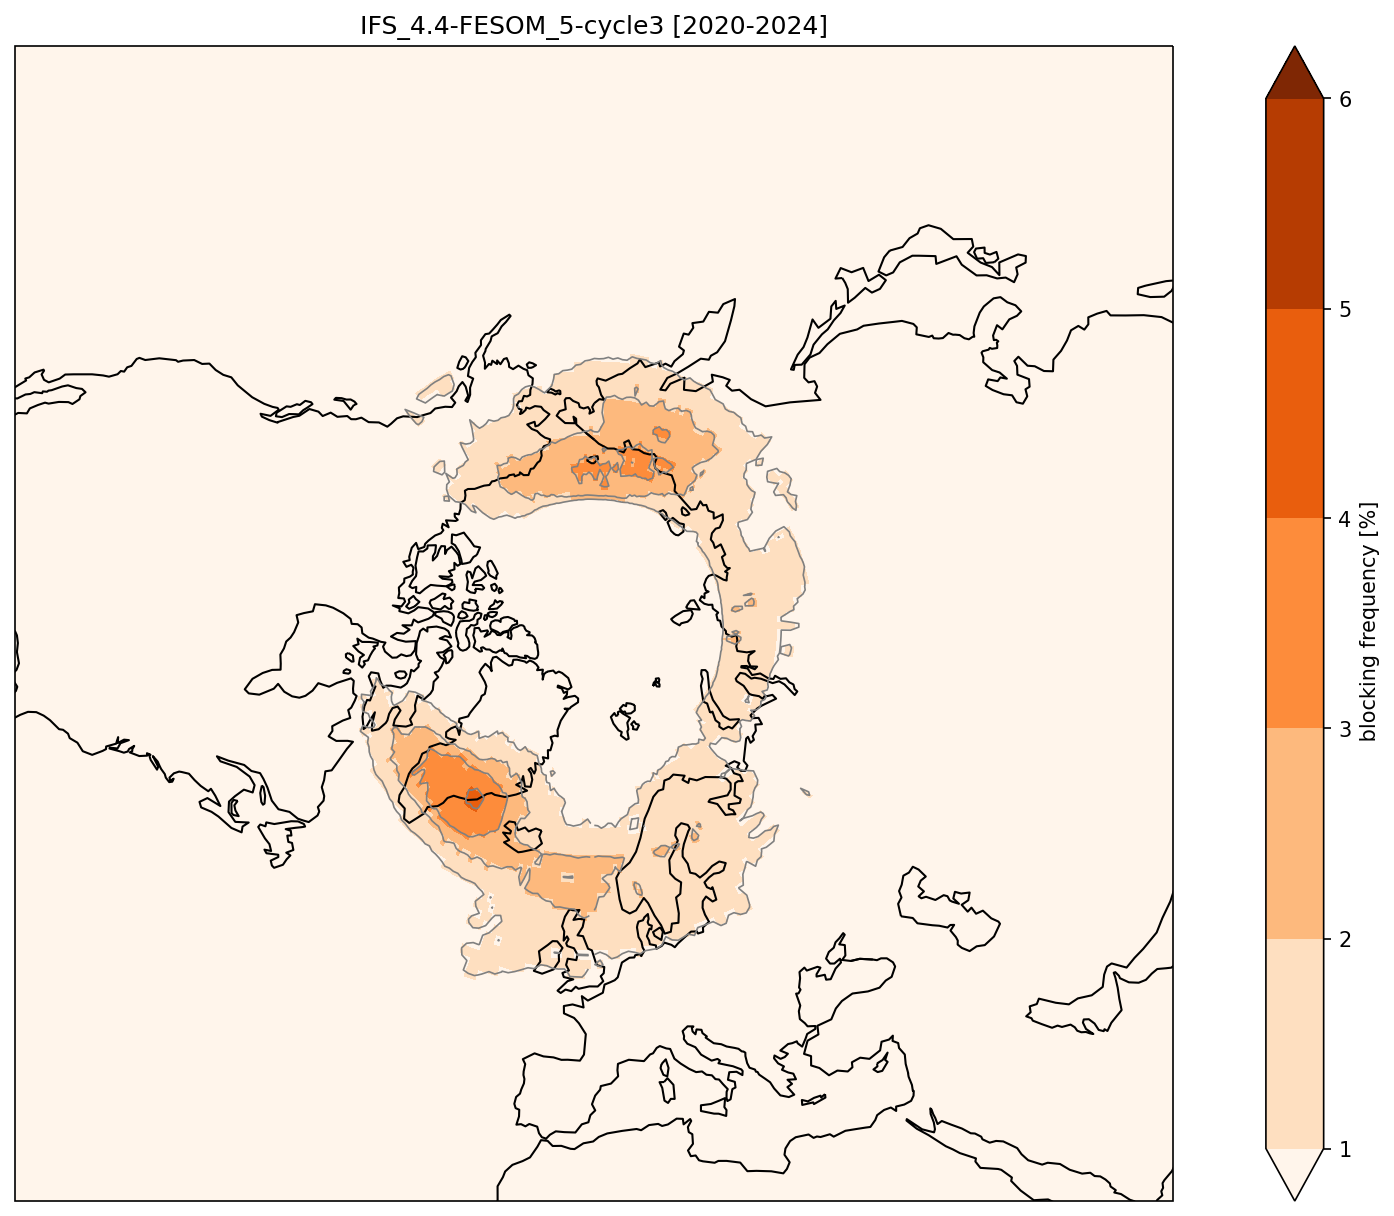

In [5]:
###### ANO Z500 index plot in DJF
sufix='DJF'
clevels=[-10,-8,-6,-5,-4,-3,-2,-1.5,-1,1,1.5,2,3,4,5,6,8,10]
mlevels=np.arange(1,7,1)
### ABS index plot in DJF
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10), dpi=150, subplot_kw={'projection': ccrs.NorthPolarStereo()})
###==== first panel
im1=acc_sims.plot(ax=ax1,levels=mlevels, cmap='Oranges', extend = 'both', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': ' blocking frequency [%]'})
acc_sims.plot.contour(ax=ax1,colors='grey', linewidths=0.8, levels=mlevels, transform=ccrs.PlateCarree())

ax1.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree()); 
ax1.coastlines();

ax1.set_title('IFS_4.4-FESOM_5-cycle3 [2020-2024]')